# Predicting the Popularity of “Flowers” Searches on Google Using Prophet 
*Adapted from Marco Peixeiro's book [Time Series Forecasting in Python](https://amzn.eu/d/eU0GuYo)*

## Introduction

Accurately predicting the popularity of search terms is crucial for retail analysts, as it enables more effective optimisation of marketing strategies. By understanding the trends in keyword searches, analysts can help marketing teams refine their bidding strategies, thus influencing the cost-per-click on advertisements and ultimately improving the overall return on investment (ROI) for marketing campaigns.

Moreover, forecasting search term trends offers deeper insights into consumer behaviour. For instance, if we can predict an increase in searches for "flowers" in the coming month, retail businesses can proactively adjust their strategies. This could involve offering timely discounts, adjusting inventory levels, and ensuring sufficient stock to meet the anticipated demand. Such insights help in aligning supply with demand, improving customer satisfaction, and driving sales growth.

In this notebook, we will employ the following models: SARIMA, Holt-Winters, and Prophet. Prophet, developed by Facebook, is a robust forecasting tool that we will use to predict future trends in "flowers" searches on Google. By analysing historical search data sourced from [Google Trends](https://trends.google.com/trends/explore?date=all&geo=GB&q=%2Fm%2F0c9ph5), we aim to create a precise model that provides actionable insights for retail analysts, enabling data-driven decision-making to enhance marketing effectiveness and operational efficiency.

We will explore the use of the Prophet library for automatic time series forecasting. Prophet uses a general additive model that combines a trend component, a seasonal component, and holiday effects. The main advantage of this library is that it allows us to quickly experiment and generate predictions. Many functions are available for visualising and understanding our models, and more advanced functions are also available, allowing us to perform cross-validation and hyperparameter tuning. While Prophet is widely used in the industry, it must not be considered a one-size-fits-all solution. Prophet works particularly well with strongly seasonal data that has many historical seasons. Thus, it is to be treated as another tool in our forecasting tool belt that can be tested along with other statistical or deep learning models.

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [256]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [257]:
fig_path = '/Users/jonathanduquegonzalez/Library/CloudStorage/OneDrive-GlobalBankingSchool/Forecasting/Predicting the popularity of “chocolate” searches on Google/Figures/flower_searches_comparison.png'

We’ll kick off this project by reading the data.

In [258]:
df = pd.read_csv('/Users/jonathanduquegonzalez/Library/CloudStorage/OneDrive-GlobalBankingSchool/Forecasting/Predicting the popularity of “chocolate” searches on Google/multiTimeline.csv')
df.head()

,Month,Flower: (United Kingdom)
0,2004-01,31
1,2004-02,40
2,2004-03,50
3,2004-04,39
4,2004-05,50


In [259]:
df.tail()

,Month,Flower: (United Kingdom)
240,2024-01,44
241,2024-02,56
242,2024-03,71
243,2024-04,63
244,2024-05,76


The DataFrame `df` contains two columns: "Month" and "Flower: (United Kingdom)". The "Month" column includes dates in the format YYYY-MM, representing the months from January 2004 to May 2024. The "Flower: (United Kingdom)" column contains numerical values representing the proportion of searches using the keyword "flowers" in the United Kingdom for each corresponding month. The DataFrame comprises 245 rows, covering the period from January 2004 to May 2024. Now, let's proceed with plotting the data:

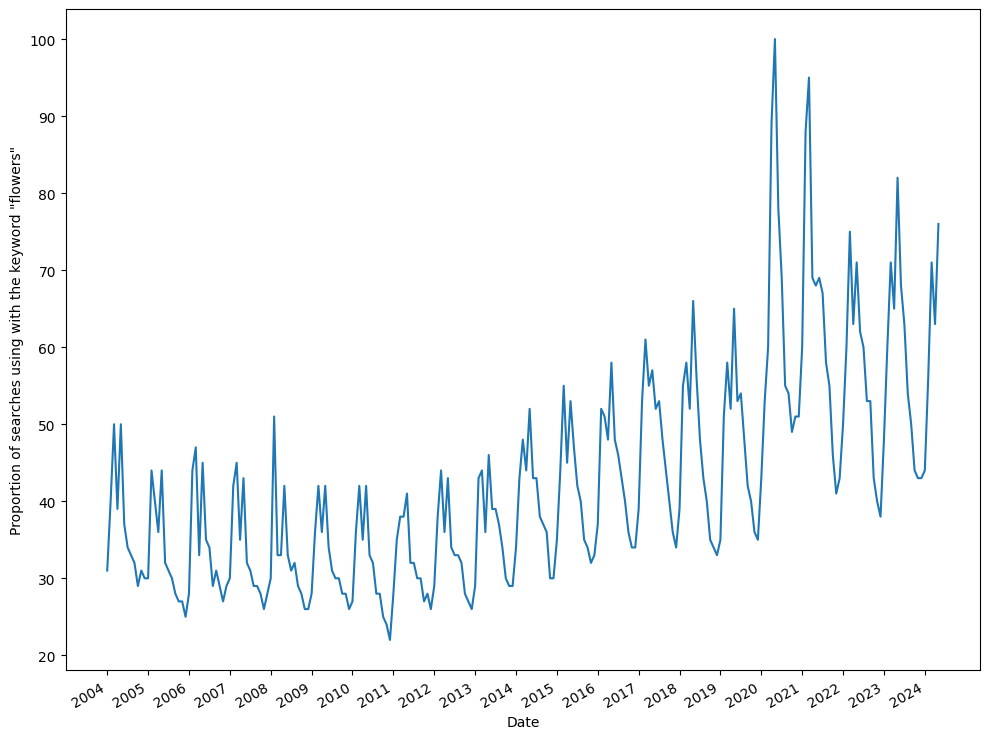

In [260]:
fig, ax = plt.subplots()

ax.plot(df['Flower: (United Kingdom)'])
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "flowers"')

# Generate labels for every 12th tick
tick_locations = np.arange(0, len(df), 12)
tick_labels = np.arange(2004, 2025, 1)[:len(tick_locations)]  

plt.xticks(tick_locations, tick_labels)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig(fig_path, dpi=300)


The data reveals a clear seasonal pattern, with periodic spikes corresponding to higher search interest, likely around specific times of the year such as holidays or special occasions. Additionally, there is a noticeable upward trend over the years, indicating a general increase in the popularity of the keyword "flowers" in Google searches within the United Kingdom.

There are two elements that make this dataset particularly interesting to model with Prophet. First, it is likely that holiday effects are at play. For example, Valentine's Day is a significant holiday in the United Kingdom, and it is quite common to offer flowers on this occasion. The second element is that we have monthly data. While Prophet can model monthly data, some adjustments must be made to ensure accurate results. Prophet works out-of-the-box with daily and sub-daily data, but monthly data requires additional tweaking.

We will rename our columns following Prophet’s naming conventions. Recall that Prophet expects the date column to be named `ds`, while the value column must be named `y`.

In [261]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01,31
1,2004-02,40
2,2004-03,50
3,2004-04,39
4,2004-05,50


We can now move on to verifying that the date is correctly formatted. In this case, we only have the year and the month, which does not conform to the YYYY-MM-DD format expected by Prophet for a timestamp. Therefore, we will add a day to our date column. Since we have monthly data, which can only be obtained at the end of the month, we will add the last day of the month to the timestamp.

In [262]:
from pandas.tseries.offsets import MonthEnd

df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)
df.head()

,ds,y
0,2004-01-31,31
1,2004-02-29,40
2,2004-03-31,50
3,2004-04-30,39
4,2004-05-31,50


## Hyperparameter Tuning and Cross-Validation

We can combine hyperparameter tuning and cross-validation in Prophet to create a robust process that automatically identifies the best parameter combination to fit our data.

Before we delve into hyperparameter tuning, we will first split our data into training and test sets to ensure that hyperparameter tuning is performed solely on the training set, thus avoiding data leakage. For this purpose, we will reserve the last twelve months of data for the test set.

### Split Data Into Training and Test Sets

In [263]:
train = df[:-12]
test = df[-12:]

In [264]:
train.tail()

,ds,y
228,2023-01-31,48
229,2023-02-28,60
230,2023-03-31,71
231,2023-04-30,65
232,2023-05-31,82


### Generating Parameter Combinations for Tuning

We’ll define a range of values for each parameter we wish to tune and build a list containing each unique combination of values.

In [265]:
from itertools import product
from prophet.diagnostics import cross_validation, performance_metrics

train = df.iloc[:-12]
test = df.iloc[-12:]

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale':  [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Create all combinations of parameters
params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

# Define cutoffs for cross-validation
end_date = train['ds'].max() - pd.DateOffset(months=12)  # 12 months before the last date in the training set

# Adjust start date to also end in May for consistency if needed
start_date = '2009-05-31'

cutoffs = pd.date_range(start=start_date, end=end_date, freq='12M')

# Perform cross-validation for each parameter combination
for param in params:
    m = Prophet(**param)
    m.add_country_holidays(country_name='UK')
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
# Store the results in a DataFrame
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

# Display the results
tuning_results

09:40:51 - cmdstanpy - INFO - Chain [1] start processing
09:40:51 - cmdstanpy - INFO - Chain [1] done processing
09:40:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:40:51 - cmdstanpy - INFO - Chain [1] start processing
09:40:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/14 [00:00<?, ?it/s]09:40:51 - cmdstanpy - INFO - Chain [1] start processing
09:40:51 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 1/14 [00:00<00:01,  7.69it/s]09:40:51 - cmdstanpy - INFO - Chain [1] start processing
09:40:51 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 2/14 [00:00<00:01,  7.40it/s]09:40:51 - cmdstanpy - INFO - Chain [1] start processing
09:40:52 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 3/14 [00:00<00:03,  3.44it/s]09:40:52 - cmdstanpy - INFO - Chain [1] start processing
09:40:52 - cmdstanpy - INFO - Chain [1] done p

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,mse
0,0.001,0.01,0.01,additive,82.523244
1,0.001,0.01,0.01,multiplicative,103.898458
2,0.001,0.01,0.10,additive,81.915519
3,0.001,0.01,0.10,multiplicative,101.986620
4,0.001,0.01,1.00,additive,79.945858
...,...,...,...,...,...
123,0.500,10.00,0.10,multiplicative,53.100550
124,0.500,10.00,1.00,additive,56.333174
125,0.500,10.00,1.00,multiplicative,54.612083
126,0.500,10.00,10.00,additive,56.349955


### Extracting Optimal Parameter Combination and Model Fitting
Once this process is over, we can extract the optimal parameter combination.

In [266]:
best_params = params[np.argmin(mses)]
best_params

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.1,
 'holidays_prior_scale': 10.0,
 'seasonality_mode': 'multiplicative'}

The best parameters based on the minimum mean squared error (MSE) are as follows: a `changepoint_prior_scale` of 0.01, indicating a preference for a smoother trend; a `seasonality_prior_scale` of 0.1, allowing for moderate seasonal variability; a `holidays_prior_scale` of 10.0, granting significant flexibility to holiday effects; and a `seasonality_mode` set to multiplicative, meaning the seasonal effects are proportional to the overall trend. This combination of parameters provides the most accurate and generalisable model for this data.

### Deriving the Optimal Parameter Combination and Evaluating Model Performance

After completing the hyperparameter tuning process, we identify the optimal parameter combination and proceed to train the model using the entire training dataset. We enhance the model by incorporating the same country-specific holidays used during cross-validation, specifically those of the United Kingdom, to improve its forecasting accuracy. Subsequently, we evaluate the model's performance using the test dataset to ensure its robustness and generalisability.

In [267]:
m = Prophet(**best_params)
m.add_country_holidays(country_name = 'UK')
m.fit(train);

09:45:28 - cmdstanpy - INFO - Chain [1] start processing
09:45:28 - cmdstanpy - INFO - Chain [1] done processing


The next step is to obtain the forecast of our model for the same period as the test set and merge them with the test set for easier evaluation and plotting.

In [268]:
future = m.make_future_dataframe(periods=12, freq='M')
forcast = m.predict(future)
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
233,2023-06-30,66.959541,60.162912,73.584867
234,2023-07-31,63.955025,57.079921,71.552210
235,2023-08-31,57.760429,50.693923,64.737068
236,2023-09-30,54.876459,47.643609,61.696067
237,2023-10-31,49.468051,42.437483,56.046140
238,2023-11-30,46.693128,39.239515,53.447330
239,2023-12-31,46.099358,39.323536,53.652042
240,2024-01-31,53.226907,46.275206,60.018029
241,2024-02-29,71.896261,64.922198,78.765496
242,2024-03-31,79.131408,72.458309,86.385112


In [269]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forcast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
233,2023-06-30,68,66.959541,60.162912,73.584867
234,2023-07-31,63,63.955025,57.079921,71.552210
235,2023-08-31,54,57.760429,50.693923,64.737068
236,2023-09-30,50,54.876459,47.643609,61.696067
237,2023-10-31,44,49.468051,42.437483,56.046140


### Establishing a Baseline Model: Capturing Seasonality and Trend

Before evaluating our model's performance, it is crucial to establish a benchmark for comparison. The plot revealed a clear seasonal pattern and an increasing trend in the proportion of searches using the keyword "flowers" in the United Kingdom. Therefore, a suitable baseline model should be able to capture both seasonality and trend. The Exponential Smoothing (Holt-Winters) method is well-suited for this task as it can capture the level, trend, and seasonal components of the time series. The Holt-Winters method, which includes both additive and multiplicative seasonality, provides a robust baseline model for this data.

In [270]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(
    train['y'], 
    trend='add', 
    seasonal='multiplicative', 
    seasonal_periods=12
).fit()

# Generate predictions
baseline = hw_model.forecast(len(test))

In [271]:
test['baseline'] = baseline.values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
233,2023-06-30,68,66.959541,60.162912,73.584867,66.482558
234,2023-07-31,63,63.955025,57.079921,71.552210,63.210312
235,2023-08-31,54,57.760429,50.693923,64.737068,56.843286
236,2023-09-30,50,54.876459,47.643609,61.696067,54.191116
237,2023-10-31,44,49.468051,42.437483,56.046140,48.898243


### Model Evaluation

Given the presence of outliers in the 2020-2021 period, it is advisable to use both the Mean Absolute Error (MAE) and Mean Squared Error (MSE) as performance metrics. MSE is particularly useful in this context because it penalises larger errors more heavily, providing a more sensitive measure of performance when outliers are present.

In [272]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

prophet_mse = mean_squared_error(test['y'], test['yhat'])
baseline_mse = mean_squared_error(test['y'], test['baseline'])

performance_comparison = pd.DataFrame({
    'Model': ['Prophet', 'Baseline'],
    'MAE': [prophet_mae, baseline_mae],
    'MSE': [prophet_mse, baseline_mse]
})

performance_comparison

,Model,MAE,MSE
0,Prophet,5.955546,51.226327
1,Baseline,5.304686,43.110201


**Mean Absolute Error (MAE)**: Both models exhibit similar MAE values, with the baseline model performing slightly better (lower MAE). This indicates that, on average, the Holt-Winters model's predictions are closer to the actual values compared to the Prophet model.

**Mean Squared Error (MSE)**: The baseline model also achieves a lower MSE compared to the Prophet model. Since MSE penalises larger errors more heavily, this suggests that the baseline model not only makes smaller errors on average but also avoids larger errors more effectively than the Prophet model.

In this case, the baseline model outperforms the Prophet model in both MAE and MSE. This could be due to the recent stationarity observed in the data, making simpler models more effective in capturing the underlying patterns. Given these results, we will explore SARIMA, an advanced model that might better capture the nuances in the data.

We can optionally plot the forecasts. Note that this plot also shows the confidence interval of the Prophet model.

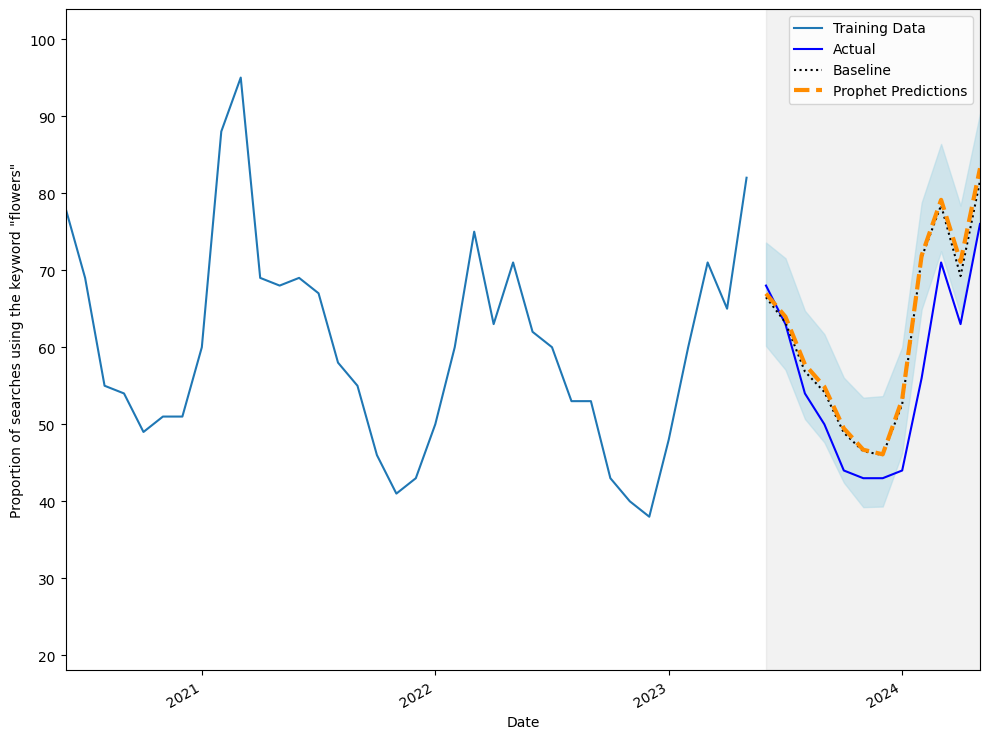

In [273]:
fig, ax = plt.subplots()

ax.plot(train.index, train['y'], label='Training Data')
ax.plot(test.index, test['y'], 'b-', label='Actual')
ax.plot(test.index, test['baseline'], 'k:', label='Baseline')
ax.plot(test.index, test['yhat'], color='darkorange', ls='--', lw=3, label='Prophet Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using the keyword "flowers"')
ax.legend(loc='best')

ax.axvspan(test.index[0], test.index[-1], color='#808080', alpha=0.1)

tick_locations = np.arange(0, len(df), 12)
tick_labels = np.arange(2004, 2025, 1)[:len(tick_locations)]  
plt.xticks(tick_locations, tick_labels)
plt.fill_between(test.index, test['yhat_lower'], test['yhat_upper'], color='lightblue', alpha=0.5)
plt.xlim(train.index[-36], test.index[-1])

fig.autofmt_xdate()

plt.tight_layout()

plt.savefig(fig_path, dpi=300)

plt.show()

### Decomposition of "Flowers" Search Trends: Trend, Holidays, and Seasonal Patterns
We can further discover how Prophet modeled our data by plotting the components of the model.

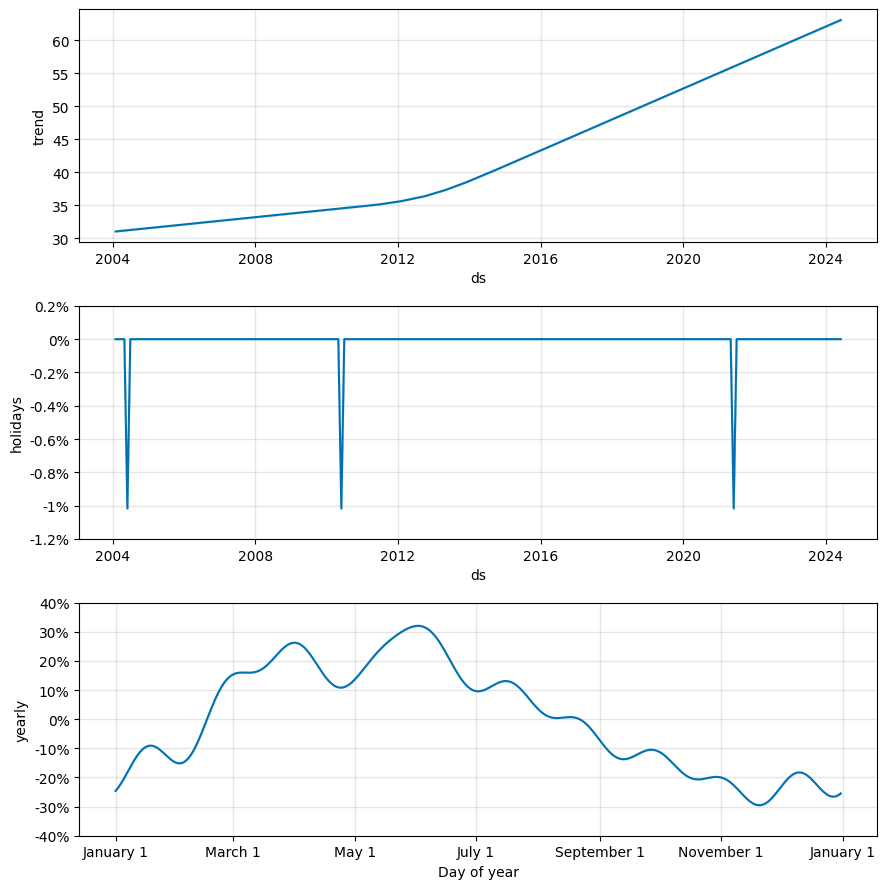

In [274]:
prophet_components_fig = m.plot_components(forcast)

plt.savefig(fig_path, dpi = 300)

The trend component indicates a clear upward trend in the popularity of "flowers" searches from 2004 to 2024, suggesting growing interest over the years. The holidays component highlights significant dips around specific holidays, indicating decreased search volumes during these periods. The yearly seasonality component reveals distinct seasonal patterns, with search interest peaking around early March and May, aligning with events like Valentine's Day and Mother's Day, and tapering off towards the end of the year.

### Experiment: Can SARIMA Do Better?
In the previous section, we used Prophet to forecast the popularity of searches on Google involving the keyword “flowers” in the United Kingdom. Our model achieved a performance similar to our baseline, the Holt-Winters Exponential Smoothing. It would be interesting to see how a SARIMA model compares to Prophet in this situation. This section provides a great opportunity to revisit our modelling skills using statistical models.

Let’s start by importing the libraries that we need:

In [275]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from itertools import product
from typing import Union

#### Checking Data Stationarity with ADF Test

Next, we’ll check whether the data is stationary using the augmented Dickey-Fuller (ADF) test.

In [276]:
ad_fuller_result = adfuller(df['y'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8808521453253565
p-value: 0.7942126670594105


The ADF statistic is -0.88 and the p-value is 0.79. The p-value is much higher than the common significance levels (e.g., 0.01, 0.05, 0.10), which indicates that we fail to reject the null hypothesis of the ADF test that the time series has a unit root, meaning it is non-stationary.

Therefore, based on the ADF test results, we conclude that the data is non-stationary. This implies that the time series data for "flowers" searches in the United Kingdom has statistical properties such as mean, variance, and autocorrelation that change over time, and further differencing or transformation is required to make the series stationary before applying the model.

Let’s difference our time series and test for stationarity again.

In [277]:
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.5002698860938555
p-value: 2.0788621972597394e-06


After differencing our time series, the results of the augmented Dickey-Fuller (ADF) test are as follows: an ADF statistic of -5.50 and a p-value of 0.00000208. The p-value is significantly lower than common significance levels (e.g., 0.01, 0.05, 0.10), indicating that we can reject the null hypothesis of the ADF test, which posits that the time series has a unit root and is non-stationary. Therefore, based on the differenced data, we conclude that the time series is now stationary. This implies that the statistical properties of the "flowers" search data are constant over time after differencing, making it suitable for time series modelling with SARIMA. Since we differenced only once and did not take a seasonal difference, we set d = 1 and D = 0. Additionally, because we have monthly data, the frequency is m = 12. As you can see, having seasonal data does not necessarily require taking a seasonal difference to achieve stationarity.

#### Optimizing SARIMA Parameters with AIC Criterion

Now, we'll use the `optimize_SARIMAX` function to find the values of \( p \), \( q \), \( P \), and \( Q \) that minimise the Akaike Information Criterion (AIC). Note that although the function includes SARIMAX in its name, it can be used to optimise any variant of the SARIMAX model. In this case, we'll optimise a SARIMA model by setting the exogenous variables to `None`.

In [278]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

To find the optimal parameters, we’ll first define a range of values for each and create a list of unique combinations. We can then pass that list to the optimize_SARIMAX function.

In [279]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12

In [280]:
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
SARIMA_result_df

100%|██████████| 256/256 [06:30<00:00,  1.53s/it]


,"(p,q,P,Q)",AIC
0,"(2, 2, 3, 1)",1357.566217
1,"(2, 2, 1, 3)",1358.502648
2,"(2, 2, 3, 2)",1358.522745
3,"(2, 2, 1, 2)",1359.046330
4,"(2, 2, 2, 1)",1360.356564
...,...,...
249,"(1, 1, 0, 0)",1604.345884
250,"(2, 2, 0, 0)",1605.370076
251,"(1, 2, 0, 0)",1605.886125
252,"(3, 0, 0, 0)",1606.015670


The lowest AIC value, indicating the best-fitting model, is 1357.566217 for the parameter combination \((2, 2, 3, 1)\). This suggests that the SARIMA model with these parameters provides the best balance of model complexity and goodness-of-fit for the "flowers" search data. Models with higher AIC values, such as those towards the bottom of the table, are less optimal. Therefore, the combination \((2, 2, 3, 1)\) should be selected for forecasting as it minimises the AIC.

 We can fit a model on the training set using those values and study its residuals.

In [281]:
best_order = (2, 1, 2)
best_seasonal_order = (3, 1, 1, 12)

SARIMA_model = SARIMAX(train['y'], order=best_order, seasonal_order=best_seasonal_order, simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  233
Model:             SARIMAX(2, 1, 2)x(3, 1, [1], 12)   Log Likelihood                -630.666
Date:                              Sat, 01 Jun 2024   AIC                           1279.332
Time:                                      09:52:07   BIC                           1309.875
Sample:                                           0   HQIC                          1291.666
                                              - 233                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5787      0.044     35.894      0.000       1.493       1.665
ar.L2         -0.85

The SARIMAX model summary shows that the model with parameters \((2, 1, 2)\) for the non-seasonal part and \((3, 1, 1, 12)\) for the seasonal part has been fitted to the data. The AIC value of 1279.332 indicates the model's goodness-of-fit, with lower values being better. The coefficients for the autoregressive (AR) and moving average (MA) terms, both non-seasonal and seasonal, are statistically significant as indicated by their p-values (most are below 0.05), suggesting they contribute meaningfully to the model. The Ljung-Box test p-value of 0.05 implies the residuals may exhibit some autocorrelation. The Jarque-Bera test p-value of 0.00 indicates that the residuals are not normally distributed. The model's heteroskedasticity (H) value suggests variability in the residuals over time. Overall, the model appears to be a good fit for the data, but the non-normality of residuals suggests that further investigation into model diagnostics may be needed.


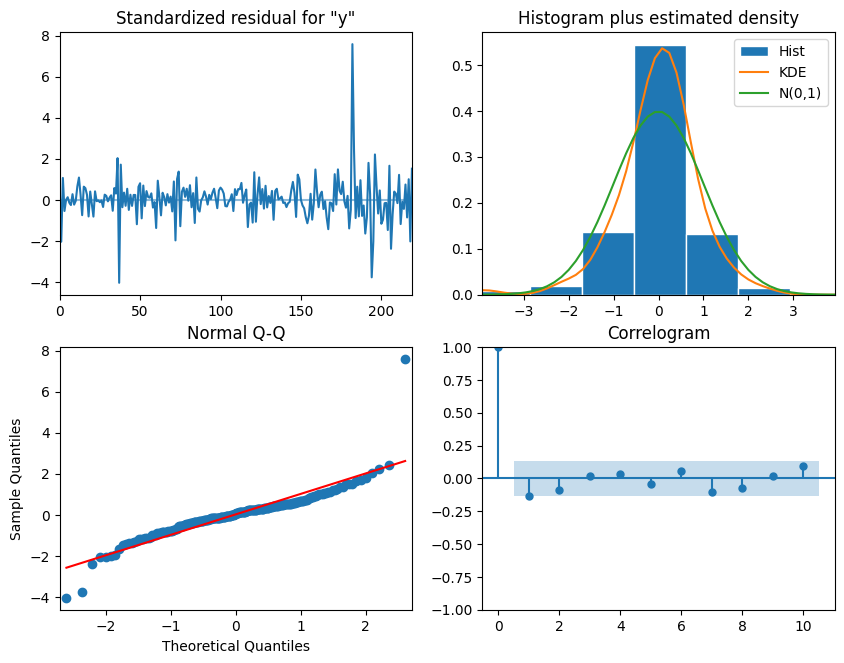

In [282]:
SARIMA_model_fit.plot_diagnostics();

plt.savefig(fig_path, dpi=300)

The diagnostic plots of the SARIMA model's residuals provide several insights into the model's performance:

1. **Standardised Residuals**: The residuals are generally centred around zero, indicating that the model's errors are balanced. However, there are occasional large spikes, suggesting some larger prediction errors.

2. **Histogram plus Estimated Density**: The residuals are approximately normally distributed, but deviations around the tails indicate more dispersion than a perfect normal distribution.

3. **Normal Q-Q Plot**: Most residuals lie close to the line, showing that they are roughly normally distributed. However, deviations at the tails suggest potential non-normality.

4. **Correlogram**: The autocorrelation values are mostly within the confidence bands, indicating that the residuals are not significantly autocorrelated, meaning the model captures most temporal dependencies.

Overall, the SARIMA model performs well with balanced residuals and no significant autocorrelation. However, occasional larger errors and deviations from normality suggest Further refinement of the model or additional diagnostics might be needed to address these issues.

#### Assessing Residuals with Ljung-Box Test
At this point, it is hard to determine whether the residuals are close enough to white noise, so we’ll use the Ljung-Box test to determine if the residuals are independent and uncorrelated.

In [283]:
residuals = SARIMA_model_fit.resid

lb_test = acorr_ljungbox(residuals, lags=np.arange(1, 11))

lbvalue = lb_test['lb_stat']
pvalue = lb_test['lb_pvalue']

df_results = pd.DataFrame({
    'Lag': np.arange(1, 11),
    'LB Value': lbvalue,
    'P-Value': pvalue
})

df_results

,Lag,LB Value,P-Value
1,1,3.231289,0.072244
2,2,4.121699,0.127346
3,3,4.861867,0.182196
4,4,5.975353,0.200997
5,5,8.405901,0.135239
6,6,8.709854,0.190565
7,7,9.301615,0.231721
8,8,10.895111,0.207713
9,9,11.772987,0.226412
10,10,11.785124,0.299695


The Ljung-Box test results for the SARIMA model's residuals show p-values greater than the common significance levels (e.g., 0.01, 0.05, 0.10) for all lags from 1 to 10. This indicates that we fail to reject the null hypothesis of no autocorrelation in the residuals at these lags. Therefore, the residuals appear to be uncorrelated, suggesting that the SARIMA model has adequately captured the temporal dependencies in the data. The low p-values at lag 1 and subsequent lags suggest that there may be slight autocorrelation at shorter lags, but overall, the model performs well in terms of residual diagnostics.

#### "Generating SARIMA Model Predictions for Test Set Period"

Next, let’s generate the predictions from the SARIMA model over the period of the test set.

In [284]:
test

,ds,y,yhat,yhat_lower,yhat_upper,baseline
233,2023-06-30,68,66.959541,60.162912,73.584867,66.482558
234,2023-07-31,63,63.955025,57.079921,71.552210,63.210312
235,2023-08-31,54,57.760429,50.693923,64.737068,56.843286
236,2023-09-30,50,54.876459,47.643609,61.696067,54.191116
237,2023-10-31,44,49.468051,42.437483,56.046140,48.898243
238,2023-11-30,43,46.693128,39.239515,53.447330,46.503165
239,2023-12-31,43,46.099358,39.323536,53.652042,45.998321
240,2024-01-31,44,53.226907,46.275206,60.018029,52.594303
241,2024-02-29,56,71.896261,64.922198,78.765496,71.651660
242,2024-03-31,71,79.131408,72.458309,86.385112,78.424784


In [285]:
start = len(train)
end = len(train) + len(test) - 1

SARIMA_pred = SARIMA_model_fit.get_prediction(start=start, end=end).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

test


,ds,y,yhat,yhat_lower,yhat_upper,baseline,SARIMA_pred
233,2023-06-30,68,66.959541,60.162912,73.584867,66.482558,69.640783
234,2023-07-31,63,63.955025,57.079921,71.552210,63.210312,64.567969
235,2023-08-31,54,57.760429,50.693923,64.737068,56.843286,55.968631
236,2023-09-30,50,54.876459,47.643609,61.696067,54.191116,51.479605
237,2023-10-31,44,49.468051,42.437483,56.046140,48.898243,46.969352
238,2023-11-30,43,46.693128,39.239515,53.447330,46.503165,45.266281
239,2023-12-31,43,46.099358,39.323536,53.652042,45.998321,45.474294
240,2024-01-31,44,53.226907,46.275206,60.018029,52.594303,52.184043
241,2024-02-29,56,71.896261,64.922198,78.765496,71.651660,69.843050
242,2024-03-31,71,79.131408,72.458309,86.385112,78.424784,76.934041


In [286]:
csv_output_path = '/Users/jonathanduquegonzalez/Library/CloudStorage/OneDrive-GlobalBankingSchool/Forecasting/Predicting the popularity of “chocolate” searches on Google/Forecasts/forecast_results.csv'
test.to_csv(csv_output_path)

#### Evaluating and Comparing SARIMA Model Performance

Finally, we will evaluate the performance of the SARIMA model and append its metrics to the existing model performance comparisons.

In [287]:
sarima_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])
sarima_mse = mean_squared_error(test['y'], test['SARIMA_pred'])

performance_comparison = pd.DataFrame({
    'Model': ['Prophet', 'Baseline', 'SARIMA'],
    'MAE': [prophet_mae, baseline_mae, sarima_mae],
    'MSE': [prophet_mse, baseline_mse, sarima_mse]
})

performance_comparison

,Model,MAE,MSE
0,Prophet,5.955546,51.226327
1,Baseline,5.304686,43.110201
2,SARIMA,4.499333,34.479586


The performance comparison table shows the Mean Absolute Error (\(MAE\)) and Mean Squared Error (\(MSE\)) for three models: Prophet, Baseline, and SARIMA. The SARIMA model outperforms the other models with the lowest \(MAE\) of \(4.499333\) and the lowest \(MSE\) of \(34.479586\). This indicates that the SARIMA model's predictions are, on average, closer to the actual values and have smaller errors compared to the Prophet and Baseline models. The Baseline model performs better than the Prophet model, with an \(MAE\) of \(5.304686\) and an \(MSE\) of \(43.110201\), compared to the Prophet model's \(MAE\) of \(5.955546\) and \(MSE\) of \(51.226327\). Thus, the SARIMA model provides the most accurate forecasts among the three models evaluated.


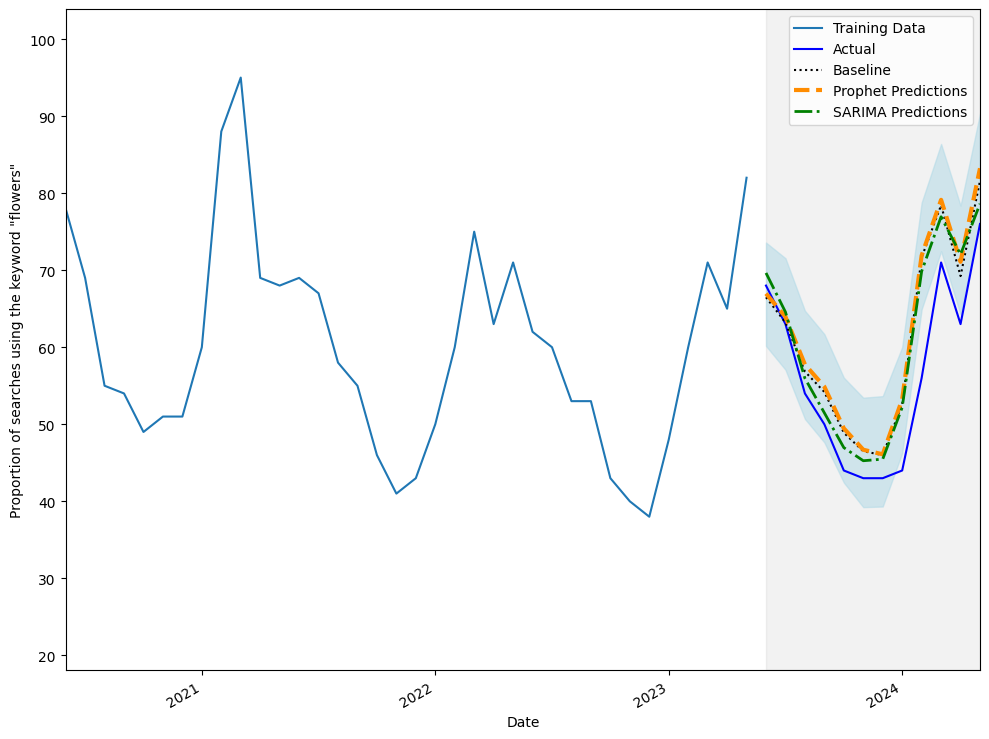

In [288]:
fig, ax = plt.subplots()

ax.plot(train.index, train['y'], label='Training Data')
ax.plot(test.index, test['y'], 'b-', label='Actual')
ax.plot(test.index, test['baseline'], 'k:', label='Baseline')
ax.plot(test.index, test['yhat'], color='darkorange', ls='--', lw=3, label='Prophet Predictions')
ax.plot(test.index, test['SARIMA_pred'], color='green', ls='-.', lw=2, label='SARIMA Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using the keyword "flowers"')
ax.legend(loc='best')

ax.axvspan(test.index[0], test.index[-1], color='#808080', alpha=0.1)

tick_locations = np.arange(0, len(df), 12)
tick_labels = np.arange(2004, 2025, 1)[:len(tick_locations)]
plt.xticks(tick_locations, tick_labels, rotation=45)

plt.fill_between(test.index, test['yhat_lower'], test['yhat_upper'], color='lightblue', alpha=0.5)

plt.xlim(train.index[-36], test.index[-1])

fig.autofmt_xdate()

plt.tight_layout()

plt.savefig(fig_path, dpi=300)

plt.show()

## Generating Future Forecasts with SARIMA

Let's generate the future forecast for the next 12 months using SARIMA, which has proven to be the best performing model.

In [289]:
forecast_horizon = 12

forecast = SARIMA_model_fit.get_forecast(steps=forecast_horizon)

last_date = test['ds'].max()
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_df = pd.DataFrame({
    'forecast': forecast_mean.values,
    'ci_lower': forecast_ci.iloc[:, 0].values,
    'ci_upper': forecast_ci.iloc[:, 1].values
}, index=forecast_index)

forecast_df

,forecast,ci_lower,ci_upper
2024-06-30,69.640783,61.652387,77.629180
2024-07-31,64.567969,54.620555,74.515383
2024-08-31,55.968631,45.328254,66.609009
2024-09-30,51.479605,40.626845,62.332366
2024-10-31,46.969352,36.029387,57.909317
2024-11-30,45.266281,34.212065,56.320498
2024-12-31,45.474294,34.128597,56.819991
2025-01-31,52.184043,40.184209,64.183878
2025-02-28,69.843050,56.758093,82.928007
2025-03-31,76.934041,62.482951,91.385130


#### Saving Forecast Results to CSV File

In [290]:
forecast_df.to_csv(csv_output_path)

### Conclusion

Nicolas Vandeput says in his book [Inventory Optimization: Models and Simulations](https://amzn.eu/d/0VEXlHI): "As supply chain scientists, we have to make trade-offs for our models between complexity and accuracy on one side, and simplicity and practicality on the other. As Jordan Ellenberg explained in his book [How Not to Be Wrong: The Power of Mathematical Thinking](https://amzn.eu/d/edXzDHa): 'If the universe hands you a hard problem, try to solve an easier one instead, and hope the simple version is close enough to the original problem that the universe doesn’t object.' This is exactly what we will do. A complex model will most likely be more accurate, resulting in fewer costs and more profits, but less understandable and usable for different users. A simple model, on the other hand, will be less accurate, resulting in higher costs and waste, but might be more usable and sustainable for a business process. At some point, it is better for a model to be 80% accurate but trusted and always used, rather than be 95% accurate and never used nor well understood. There is a Latin saying, 'Vires acquirit eundo,' which means, 'We gather strength as we go.' This represents perfectly the path we will follow in this book: as shown in Figure 2, we will start with a simple model and, as we apply it, we will learn new things. These will allow us to build a stronger model. And so on. We will gather insights and intuitions about supply chains as we go."